<a href="https://colab.research.google.com/github/chrisli36/Homework-Classification/blob/main/knn_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from skimage import io, color, transform
import matplotlib.pyplot as plt
import os
import cv2

# Function to load and preprocess images
def preprocess_image(image_path, target_size=(32, 32)):
    image = io.imread(image_path)
    image = color.rgb2gray(image)  # Convert to grayscale
    # image = transform.resize(image, target_size)  # Resize image
    # # Flatten the image to create a 1D array
    # return image.flatten()
    return cv2.resize(image, target_size).flatten()

# Load and preprocess images from two classes
dataset_path = "data/hw"
path = "data/no_hw"
class_0_paths = [os.path.join(dataset_path, fn) for fn in os.listdir(dataset_path)]
class_1_paths = [os.path.join(path, fn) for fn in os.listdir(path)]
print("done finding paths")

class_0_data = np.array([preprocess_image(path) for path in class_0_paths])
class_1_data = np.array([preprocess_image(path) for path in class_1_paths[:200]])
print("done preprocessing")

# Create labels for the data
class_0_labels = np.zeros(class_0_data.shape[0])  # Label for class 0
class_1_labels = np.ones(class_1_data.shape[0])   # Label for class 1
print("done creating labels")

# Combine data and labels for both classes
X = np.concatenate((class_0_data, class_1_data), axis=0)
y = np.concatenate((class_0_labels, class_1_labels), axis=0)
print("done combining")

done finding paths


KeyboardInterrupt: 

0.8909774436090225
Accuracy: 0.835820895522388


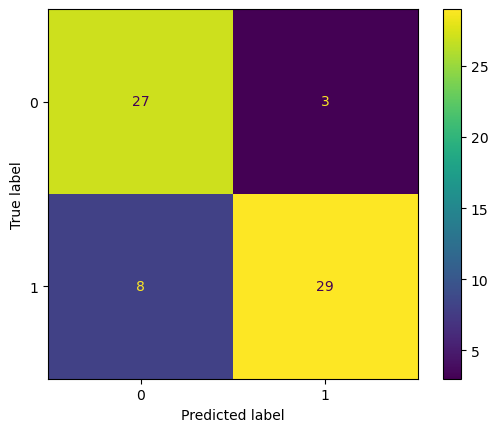

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors (k) as needed

# Train the classifier
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()
plt.show()